In [3]:
# можно закомментировать, если код выполняется в colab или kaggle. я запускался на ШАДовксом кластере, где trl умеет параллелить вычисления
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=6,7

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=6,7


In [4]:
# !nvidia-smi -g 0 -c 0

In [5]:
import torch
import torch.nn.functional as F

import trl

In [ ]:
import gc

def clear_device():    
    gc.collect()
    torch.cuda.empty_cache()

In [6]:
assert torch.cuda.is_available()

In [7]:
from dataclasses import dataclass

@dataclass
class RLHFSettings:
    SFT_MODEL_NAME = "HuggingFaceTB/SmolLM2-135M-Instruct"
    MAX_LENGTH = 512

@dataclass
class RewardSettings:
    EPOCHS = 1
    LR = 5e-5
    TRAIN_BATCH_SIZE = 64
    EVAL_BATCH_SIZE = 64


@dataclass
class ReinforceSettings:
    EVAL_BATCH_SIZE = 32
    TRAIN_BATCH_SIZE = 4
    LR = 5e-5
    EPOCHS = 1
    GRADIENT_ACCUMULATION_STEPS = 5


In [8]:
import json
from pathlib import Path

def save_metrics(metrics: dict, filename: str):

    metrics_path = Path("./metrics")    
    metrics_path.mkdir(parents=True, exist_ok=True)
    file_path = metrics_path / filename

    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(metrics, f, ensure_ascii=False, indent=4)
    
    print(f"Метрики сохранены в файл: {file_path}")

In [9]:
from datasets import load_dataset, DatasetDict


def get_dataset(
    test_size=0.2,
    train_subset_sizes: int | None = None,
    val_subset_size: int | None = None,
) -> DatasetDict:
    dataset = load_dataset("esfrankel17/original_HelpSteer2_binarized")[
        "average_rating"
    ]
    dataset = dataset.train_test_split(test_size=test_size, seed=42)

    if train_subset_sizes is not None:
        dataset["train"] = dataset["train"].select(range(train_subset_sizes))
    if val_subset_size is not None:
        dataset["test"] = dataset["test"].select(range(val_subset_size))

    return dataset

from transformers import AutoTokenizer

def get_tokenizer(tokenizer_path: str):
    tokenizer = AutoTokenizer.from_pretrained(tokenizer_path, padding_side="left")
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
    return tokenizer



In [10]:
def extract_text(data):
    return "\n".join(
        [f"{item['role'].capitalize()}: {item['content']}" for item in data]
    )

def format_reward_dataset(example, tokenizer, max_len=512):
    prompt_chosen = extract_text(example["chosen"])
    prompt_rejected = extract_text(example["rejected"])

    kwargs = {
        "padding": "max_length",
        "truncation": True,
        "max_length": max_len,
        "return_tensors": "pt",
    }
    tokens_chosen = tokenizer.encode_plus(prompt_chosen, **kwargs)
    tokens_rejected = tokenizer.encode_plus(prompt_rejected, **kwargs)

    return {
        "input_ids_chosen": tokens_chosen["input_ids"][0],
        "attention_mask_chosen": tokens_chosen["attention_mask"][0],
        "input_ids_rejected": tokens_rejected["input_ids"][0],
        "attention_mask_rejected": tokens_rejected["attention_mask"][0],
    }

## Reward


In [11]:
from trl import RewardTrainer, RewardConfig

def get_default_reward_trainer(output_model_dir, model, tokenizer, train_dataset, eval_dataset):
    training_args = RewardConfig(
        output_dir=output_model_dir,
        per_device_train_batch_size=RewardSettings.TRAIN_BATCH_SIZE,
        per_device_eval_batch_size=RewardSettings.EVAL_BATCH_SIZE,
        num_train_epochs=RewardSettings.EPOCHS,
        learning_rate=RewardSettings.LR,
        gradient_accumulation_steps=1,
        fp16=True,
        eval_strategy="steps",
        eval_steps=200,
        logging_steps=25,
        max_length=RLHFSettings.MAX_LENGTH,
        remove_unused_columns=True,
        report_to="none",
        gradient_checkpointing=True,
        dataloader_num_workers=4,
    )

    trainer = RewardTrainer(
        model=model,
        processing_class=tokenizer,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
    )

    return trainer

In [12]:
from transformers import AutoModelForSequenceClassification

def train_reward_model(output_model_dir, get_trainer_func: callable, device="cuda", num_reward_labels=1):

    model = AutoModelForSequenceClassification.from_pretrained(
        RLHFSettings.SFT_MODEL_NAME, num_labels=num_reward_labels
    ).to(device)

    tokenizer = get_tokenizer(RLHFSettings.SFT_MODEL_NAME)

    for param in model.parameters():
        param.requires_grad = True

    dataset = get_dataset()
    dataset = dataset.map(lambda ex: format_reward_dataset(ex, tokenizer))
    train_dataset = dataset["train"]
    eval_dataset = dataset["test"]

    trainer = get_trainer_func(
        output_model_dir, model, tokenizer, train_dataset, eval_dataset
    )

    metrics = {}
    metrics["default"] = trainer.evaluate()
    print("pretrained metrics", metrics["default"])

    trainer.train()
    trainer.save_model(output_model_dir)

    metrics["final"] = trainer.evaluate()

    return metrics, model

Так как подхода к получению reward-оценок планируется 2, давайте напишем обертку для агрегации выходов


In [13]:
from abc import ABC, abstractmethod

class RewardModelWrapper(ABC):
    def __init__(self, model, tokenizer, device: str = 'cpu'):
            
        self.model = model.to(device)
        self.tokenizer = tokenizer
        self.device = device
        self.model.eval()
    
    @torch.no_grad()
    def _get_logits(self, texts: list[str]) -> torch.Tensor:
        inputs = self.tokenizer(
            texts, 
            return_tensors="pt", 
            padding=True, 
            truncation=True, 
            max_length=512
        ).to(self.device)
        
        return self.model(**inputs).logits
    
    @abstractmethod
    def get_rewards(self, texts: list[str]) -> torch.Tensor:
        pass


In [14]:
class ScoreRewardModelWrapper(RewardModelWrapper):
    def get_rewards(self, texts):
        logits = self._get_logits(texts)
        return logits.squeeze(-1)

Обучим модель (если еще не обучена)

In [ ]:
# device=torch.device("cuda")
# metrics, reward_model = train_reward_model("./models/lv1/reward/model1", get_default_reward_trainer, device)

# save_metrics(metrics, "reward_default.json")
# metrics

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at HuggingFaceTB/SmolLM2-135M-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/6942 [00:00<?, ? examples/s]

Map:   0%|          | 0/1736 [00:00<?, ? examples/s]

/home/byzovti/.conda/envs/tmaga0/lib/python3.13/site-packages/trl/trainer/reward_trainer.py:192: UserWarning: When using RewardDataCollatorWithPadding, you should set `remove_unused_columns=False` in your RewardConfig we have set it for you, but you should do it yourself in the future.
  warnings.warn(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just

/home/byzovti/.conda/envs/tmaga0/lib/python3.13/site-packages/trl/trainer/utils.py:815: UserWarning: There are 189 out of 1736 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


pretrained metrics {'eval_loss': 0.806454062461853, 'eval_accuracy': 0.5171299288946348, 'eval_runtime': 45.7874, 'eval_samples_per_second': 37.914, 'eval_steps_per_second': 0.306}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Step,Training Loss,Validation Loss


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Метрики сохранены в файл: metrics/reward_default


/home/byzovti/.conda/envs/tmaga0/lib/python3.13/site-packages/trl/trainer/utils.py:815: UserWarning: There are 189 out of 1736 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


{'default': {'eval_loss': 0.806454062461853,
  'eval_accuracy': 0.5171299288946348,
  'eval_runtime': 45.7874,
  'eval_samples_per_second': 37.914,
  'eval_steps_per_second': 0.306},
 'final': {'eval_loss': 0.694042980670929,
  'eval_accuracy': 0.5843568196509373,
  'eval_runtime': 45.8396,
  'eval_samples_per_second': 37.871,
  'eval_steps_per_second': 0.305,
  'epoch': 1.0}}

Accuracy вырос с 0.51 до 0.6

sanity check reward модели

In [37]:
def sanity_check_reward(reward_wrapper: RewardModelWrapper) -> bool:
    dataset = get_dataset(train_subset_sizes=1, val_subset_size=1)
    good_text = extract_text(dataset["train"][0]["chosen"])
    bad_text = extract_text(dataset["train"][0]["rejected"])

    rewards = reward_wrapper.get_rewards([good_text, bad_text])
    good_reward, bad_reward = rewards[0].item(), rewards[1].item()

    # print(f"Текст (хороший): '{good_text}'")
    # print(f"Оценка: {good_reward:.4f}\n")
    # print(f"Текст (плохой): '{bad_text}'")
    # print(f"Оценка: {bad_reward:.4f}\n")

    if good_reward > bad_reward:
        print("✅ Sanity check пройден: 'хороший' ответ получил более высокую оценку.")
        return True
    else:
        print("❌ Sanity check не пройден: 'плохой' ответ получил оценку выше или равную 'хорошему'.")
        return False


In [16]:
from transformers import AutoModelForSequenceClassification

assert sanity_check_reward(
    ScoreRewardModelWrapper(
        model=AutoModelForSequenceClassification.from_pretrained(
            "./models/lv1/reward/model1"
        ),
        tokenizer=get_tokenizer(RLHFSettings.SFT_MODEL_NAME),
        device="cpu",
    )
)

✅ Sanity check пройден: 'хороший' ответ получил более высокую оценку.


## Reinforce

In [17]:
from tqdm import tqdm
import numpy as np
import torch


def evaluate(
    model,
    dataloader,
    tokenizer,
    reward_wrapper,
    device: torch.device,
) -> tuple[np.floating, list[float]]:
    """Evaluates the model on a given dataloader."""

    model.eval()
    all_rewards = []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluation"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            generated = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=RLHFSettings.MAX_LENGTH,
                pad_token_id=tokenizer.pad_token_id,
            )
            decode_generated = tokenizer.batch_decode(generated, skip_special_tokens=True)
            rewards = reward_wrapper.get_rewards(decode_generated)
            all_rewards.extend(rewards.cpu().numpy().tolist())
    return np.mean(all_rewards), all_rewards


In [18]:
def format_reinforce_dataset(example, tokenizer):
    "Sample for REINFORCE w/ baseline."

    def extract_prompt(conversation):
        return (
            "\n".join(
                [
                    f"{turn['role'].capitalize()}: {turn['content']}"
                    for turn in conversation[:-1]
                ]
            )
            + "\nAssistant: "
        )

    tokens = tokenizer(
        extract_prompt(example["chosen"]),
        padding="max_length",
        truncation=True,
        max_length=RLHFSettings.MAX_LENGTH,
        return_tensors="pt",
    )

    return {k: v[0] for k, v in tokens.items()}

Нам нужно подглядывать за графиками обучения по лоссу и реварду модели

In [19]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_metrics(metrics, save_path=None):
    clear_output(wait=True)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    ax1, ax2 = axes

    # --- График Loss ---
    ax1.plot(metrics["steps"], metrics["losses"], color="tab:red")
    ax1.set_title("Train Loss")
    ax1.set_xlabel("Шаги обучения")
    ax1.set_ylabel("Loss")
    ax1.grid(True)

    # --- График Reward ---
    ax2.plot(metrics["steps"], metrics["rewards"], color="tab:blue")
    ax2.set_title("Reward")
    ax2.set_xlabel("Шаги обучения")
    ax2.set_ylabel("Mean Reward")
    ax2.grid(True)

    fig.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"График сохранен в: {save_path}")

    plt.show()

Имплементируем reinforce обучение с алгоритмом REINFORCE with baseline. В видеокарту (A4000 16GB) на обучении влезает батч размера 4, и, чтобы добиться сходимости, я добавил gradien accumaulation


In [20]:
from transformers import AutoModelForCausalLM, AutoModelForSequenceClassification
from torch.utils.data import DataLoader


def train_reinforce(
        reward_wrapper: RewardModelWrapper, 
        output_model_dir: str, 
        plot_save_path:str, 
        device="cuda"
    ):
    tokenizer = get_tokenizer(RLHFSettings.SFT_MODEL_NAME)
    model = AutoModelForCausalLM.from_pretrained(RLHFSettings.SFT_MODEL_NAME).to(device)

    dataset = get_dataset(test_size=0.2, train_subset_sizes=1000, val_subset_size=300)
    train_dataset = dataset["train"].map(
        lambda ex: format_reinforce_dataset(ex, tokenizer)
    )
    val_dataset = dataset["test"].map(
        lambda ex: format_reinforce_dataset(ex, tokenizer)
    )
    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])
    val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

    train_loader = DataLoader(
        train_dataset,
        batch_size=ReinforceSettings.TRAIN_BATCH_SIZE,
        shuffle=True,
        num_workers=4,
    )
    val_loader = DataLoader(val_dataset, batch_size=ReinforceSettings.EVAL_BATCH_SIZE)

    optimizer = torch.optim.AdamW(model.parameters(), lr=ReinforceSettings.LR)

    mean_reward_before, _ = evaluate(
        model,
        val_loader,
        tokenizer,
        reward_wrapper,
        device,
    )  # TODO: можно скомпоноать модели и токенайзеры
    print(f"Initial mean reward: {mean_reward_before:.4f}")

    # --- REINFORCE Algorithm ---
    baseline = 0.0
    ema_decay = 0.99

    for epoch in range(ReinforceSettings.EPOCHS):
        print(f"Training Epoch {epoch + 1}")
        model.train()

        metrics = {
            "losses": [],
            "rewards": [],
            "steps": [],
        }

        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            prompt_len = input_ids.shape[1]

            outputs = model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_new_tokens=RLHFSettings.MAX_LENGTH,
                pad_token_id=tokenizer.pad_token_id,
                return_dict_in_generate=True,
                output_scores=True,
            )

            full_sequences = outputs.sequences
            generated_tokens = full_sequences[:, prompt_len:]

            rewards = reward_wrapper.get_rewards(tokenizer.batch_decode(generated_tokens, skip_special_tokens=True))

            # Calculate log probabilities of generated tokens
            full_attention_mask = (full_sequences != tokenizer.pad_token_id).long()
            logits = model(full_sequences, attention_mask=full_attention_mask).logits

            # Select logits for the generated tokens
            log_probs = torch.log_softmax(logits[:, prompt_len - 1 : -1], dim=-1)
            selected_log_probs = log_probs.gather(
                -1, generated_tokens.unsqueeze(-1)
            ).squeeze(-1)

            # Mask out padding tokens from loss calculation
            gen_mask = (generated_tokens != tokenizer.pad_token_id).float()
            aggregated_log_probs = (selected_log_probs * gen_mask).sum(dim=1)

            # EMA
            current_mean_reward = rewards.mean().item()
            if baseline == 0.0:  # Инициализация на первом шаге
                baseline = current_mean_reward
            else:
                baseline = ema_decay * baseline + (1 - ema_decay) * current_mean_reward

            advantages = rewards - baseline
            loss = -(advantages.detach() * aggregated_log_probs).mean()
            loss = loss / ReinforceSettings.GRADIENT_ACCUMULATION_STEPS
            loss.backward()

            if (batch_idx + 1) % ReinforceSettings.GRADIENT_ACCUMULATION_STEPS == 0 or (
                batch_idx + 1 == len(train_loader)
            ):
                optimizer.step()
                optimizer.zero_grad()

                metrics["rewards"].append(current_mean_reward)
                metrics["losses"].append(loss.item())
                metrics["steps"].append(epoch * len(train_loader) + batch_idx + 1)

            if (batch_idx + 1) % ReinforceSettings.GRADIENT_ACCUMULATION_STEPS == 0:
                plot_metrics(metrics)
            

    plot_metrics(metrics, plot_save_path)
    mean_reward_after, _ = evaluate(
        model, val_loader, tokenizer, reward_wrapper, device
    )
    print(f"Default mean reward: {mean_reward_before:.4f}")
    print(f"Final mean reward: {mean_reward_after:.4f}")

    # os.makedirs(output_model_dir, exist_ok=True)
    model.save_pretrained(output_model_dir)
    print("Model saved to:", output_model_dir)

## LEVEL 1

График сохранен в: ./plots/reinforce1


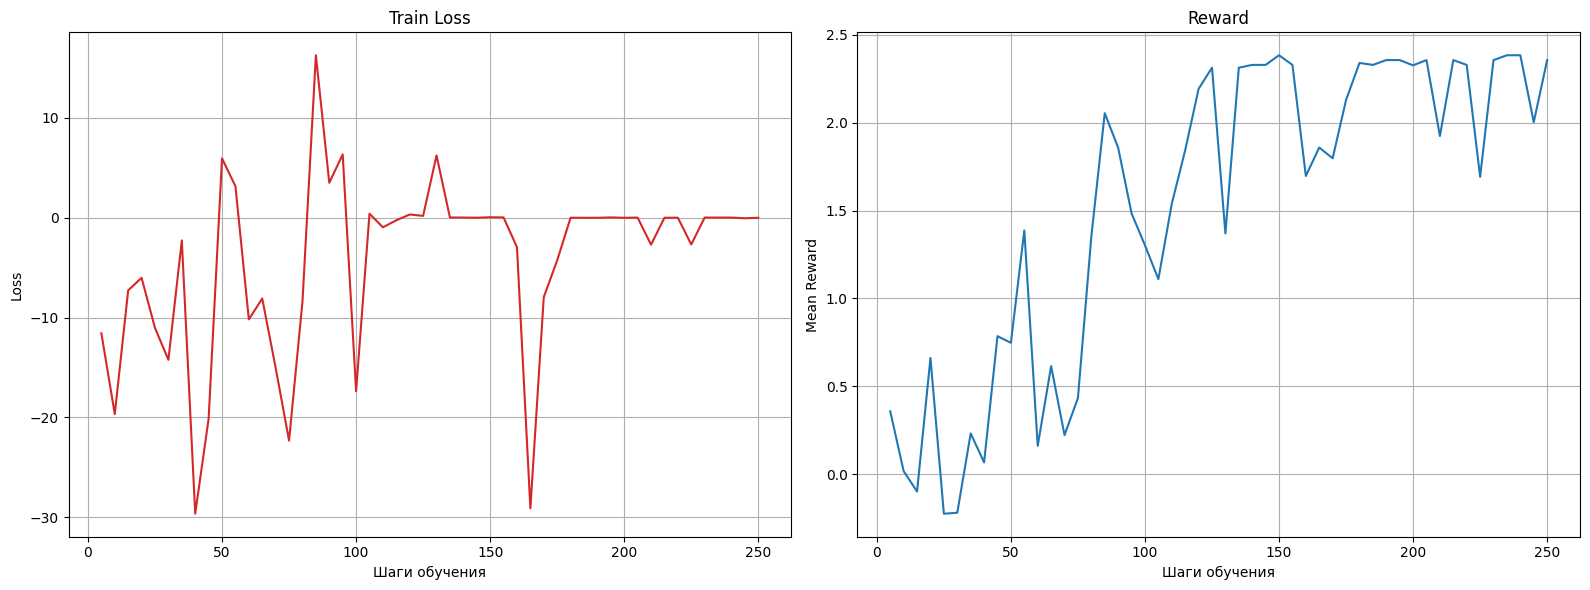

Evaluation: 100%|██████████| 10/10 [04:02<00:00, 24.25s/it]


Default mean reward: 0.3855
Final mean reward: 1.6430
Model saved to: ./models/lv1/reinforce/model1


In [19]:
device = torch.device("cuda")

reward_wrapper = ScoreRewardModelWrapper(
    tokenizer=get_tokenizer(RLHFSettings.SFT_MODEL_NAME),
    model=AutoModelForSequenceClassification.from_pretrained(
        "./models/lv1/reward/model1"
    ),
    device=device,
)
train_reinforce(
    reward_wrapper, "./models/lv1/reinforce/model1", "./plots/reinforce1", device
)

![img](./plots/reinforce1.png)

Default mean reward: 0.3855
Final mean reward: 1.6430

## LEVEL 2


In [21]:
NUM_LABELS = 10

### Доработаем Rewaed модель под вероятностную природу

In [22]:
class CustomRewardTrainer(RewardTrainer):

    def __init__(self, *args, loss_function: callable, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_func = loss_function

    def compute_loss(
        self,
        model,
        inputs: dict[str, torch.Tensor],
        return_outputs: bool = False,
        num_items_in_batch=None,
    ) -> torch.Tensor | tuple[torch.Tensor, dict[str, torch.Tensor]]:
        logits_w = model(
            input_ids=inputs["input_ids_chosen"],
            attention_mask=inputs["attention_mask_chosen"],
            return_dict=True,
        ).logits
        logits_l = model(
            input_ids=inputs["input_ids_rejected"],
            attention_mask=inputs["attention_mask_rejected"],
            return_dict=True,
        ).logits
        probs_w = torch.softmax(logits_w, dim=-1)
        probs_l = torch.softmax(logits_l, dim=-1)

        loss = self.loss_func(
            probs_w,
            probs_l,
        )

        if return_outputs:
            return loss, {
                "probs_w": probs_w,
                "probs_l": probs_l,
            }
        return loss

    def prediction_step(
        self,
        model,
        inputs: dict[str, torch.Tensor],
        prediction_loss_only: bool,
        ignore_keys: list[str] | None = None,
    ) -> tuple[torch.Tensor | None, torch.Tensor | None, torch.Tensor | None]:
        inputs = self._prepare_inputs(inputs)
        if ignore_keys is None:
            if hasattr(self.model, "config"):
                ignore_keys = getattr(
                    self.model.config, "keys_to_ignore_at_inference", []
                )
            else:
                ignore_keys = []

        with torch.no_grad():
            loss, logits_dict = self.compute_loss(model, inputs, return_outputs=True)

        if prediction_loss_only:
            return (loss, None, None)

        loss = loss.detach()

        probs_w = logits_dict["probs_w"]
        probs_l = logits_dict["probs_l"]
        ratings = torch.arange(
            1,
            probs_w.size(-1) + 1,
            device=probs_w.device,
            dtype=probs_w.dtype,
        )  # [1, 2, ... num_labels]
        expected_chosen = (probs_w * ratings).sum(dim=-1)
        expected_rejected = (probs_l * ratings).sum(dim=-1)
        logits = torch.stack([expected_chosen, expected_rejected], dim=-1)

        labels = torch.zeros(
            expected_chosen.size(0), device=expected_chosen.device, dtype=torch.long
        )

        return loss, logits, labels


In [31]:
class ClfRewardWraper(RewardModelWrapper):
    def get_rewards(self, texts):
        logits = self._get_logits(texts)
        return torch.argmax(logits, dim=-1).float() + 1


### Функция потерь 1


Понятно, что $E[s|x, y] = \sum_{i=1}^{10} i \cdot P(s=i | x, y)$

Тогда пусть:
$r_w = E[s|x, y_w]$ и $r_l = E[s|x, y_l]$

И мы можем свести выражение к обчному Reward лоссу (Bradley-Terry модель):
$L(x, y_w, y_l) = -E_{(x, y_w, y_l) \in D}[\log(\sigma(r_w - r_l))]$, который мы уже умеем оптимизировать

In [24]:
def naive_prob_loss(probs_w, probs_l):
        # Создаем тензор для вычисления матожидания "на лету"
        num_labels = probs_w.shape[-1]
        scores_tensor = torch.arange(1, num_labels + 1, device=probs_w.device, dtype=torch.float32)
        expected_score_chosen = (probs_w * scores_tensor).sum(dim=-1)
        expected_score_rejected = (probs_l * scores_tensor).sum(dim=-1)

        # Вычисляем loss: -log(sigmoid(E[chosen] - E[rejected]))
        loss = -F.logsigmoid(expected_score_chosen - expected_score_rejected).mean()
        return loss

In [25]:
def get_naive_prob_trainer(output_model_dir, model, tokenizer, train_dataset, eval_dataset):
    training_args = RewardConfig(
        output_dir=output_model_dir,
        per_device_train_batch_size=RewardSettings.TRAIN_BATCH_SIZE,
        per_device_eval_batch_size=RewardSettings.EVAL_BATCH_SIZE,
        num_train_epochs=RewardSettings.EPOCHS,
        learning_rate=RewardSettings.LR,
        fp16=True,
        logging_steps=1,
        eval_strategy="epoch",
        remove_unused_columns=False, # Важно, т.к. мы используем кастомные колонки
        report_to="none",
        
        gradient_checkpointing=True,
        dataloader_num_workers=4,
    )

    trainer = CustomRewardTrainer(
        loss_function=naive_prob_loss,
        model=model,
        processing_class=tokenizer,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
    )

    return trainer

In [30]:
prob_reward_mertics, prob_reward_model = train_reward_model("./models/lv2/reward/model1", get_naive_prob_trainer, num_reward_labels=NUM_LABELS)

save_metrics(prob_reward_mertics, "reward_naive_prob.json")
prob_reward_mertics

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at HuggingFaceTB/SmolLM2-135M-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, aft

/home/byzovti/.conda/envs/tmaga0/lib/python3.13/site-packages/trl/trainer/utils.py:815: UserWarning: There are 189 out of 1736 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


pretrained metrics {'eval_loss': 0.812110424041748, 'eval_accuracy': 0.48739495798319327, 'eval_runtime': 45.2959, 'eval_samples_per_second': 38.326, 'eval_steps_per_second': 0.309}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,Accuracy
1,0.666800,0.690477,0.562379


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Метрики сохранены в файл: metrics/reward_naive_prob.json


{'default': {'eval_loss': 0.812110424041748,
  'eval_accuracy': 0.48739495798319327,
  'eval_runtime': 45.2959,
  'eval_samples_per_second': 38.326,
  'eval_steps_per_second': 0.309},
 'final': {'eval_loss': 0.6904765367507935,
  'eval_accuracy': 0.5623787976729153,
  'eval_runtime': 45.9967,
  'eval_samples_per_second': 37.742,
  'eval_steps_per_second': 0.304,
  'epoch': 1.0}}

In [38]:
sanity_check_reward(
    ClfRewardWraper(
        tokenizer=get_tokenizer(RLHFSettings.SFT_MODEL_NAME),
        model=AutoModelForSequenceClassification.from_pretrained(
            "./models/lv2/reward/model1"
        ),
        device="cpu",
    )
)

❌ Sanity check не пройден: 'плохой' ответ получил оценку выше или равную 'хорошему'.


False

Модель не проходит sanity check ...

На двух случайных текстах логиты классов reward'a имеют следующие значения.

good: [-4.1186,  1.5412,  1.6056, -1.8219,  5.7619,  1.8166, -0.0647,  0.4995, 0.7026, -2.6734]

bad: [-4.2168,  1.3883,  1.1636, -2.0543,  5.7150,  3.0130, -0.6192,  1.2283, 0.4289, -2.5724]

Видно, что модель не обучилась достаточно, чтобы различить два класса. Хотя думаю проблема здесь не в обучнии, т к в случае good модель больше уверена в reward'e, чем в случае bad, а значит можно догадаться, где good, а где bad. Мы никак не учитываем уверенность модели в классе. Можно было бы учитывать колебания модели путем увеличения количества классов, но по итогу задача сведется к бесконечному их количеству, то бишь к стандартному подходу с одной логитой )
Следующей функцией потерь я попробую заставить модель обучиться получше.

### Функция потерь 2

Давайте пошагово разберем, как выводится и работает функция потерь в вашем `CustomRewardTrainer`.

#### 1. Цель

Основная цель — максимизировать вероятность того, что случайно выбранная оценка для "победителя" ($S_w$) будет строго больше, чем случайно выбранная оценка для "проигравшего" ($S_l$).

Математически это записывается как: **максимизировать $P(S_w > S_l)$**.

#### 2. Вывод формулы

Пусть модель для "победителя" $y_w$ предсказала распределение вероятностей $P_w = [p_{w,1}, p_{w,2}, ..., p_{w,N}]$, где $p_{w,i} = P(S_w=i)$. Аналогично для "проигравшего" $y_l$ есть распределение $P_l = [p_{l,1}, p_{l,2}, ..., p_{l,N}]$.

По закону полной вероятности, $P(S_w > S_l)$ — это сумма вероятностей всех несовместных событий, где оценка "победителя" $i$ больше оценки "проигравшего" $j$.

$P(S_w > S_l) = \sum_{i=2}^{N} \sum_{j=1}^{i-1} P(S_w=i \text{ и } S_l=j)$

Поскольку модель оценивает $y_w$ и $y_l$ независимо, мы можем записать:

$P(S_w=i \text{ и } S_l=j) = P(S_w=i) \cdot P(S_l=j) = p_{w,i} \cdot p_{l,j}$

Итоговая формула:

$P(S_w > S_l) = \sum_{i=2}^{N} \sum_{j=1}^{i-1} p_{w,i} \cdot p_{l,j}$, что на практике конечно удобно считать через $\Sigma \log(P)$

$L(x, y_w, y_l) = -E_{(x, y_w, y_l) \in D} \left[ \log \left( \sum_{i=2}^{N} \sum_{j=1}^{i-1} P(S=i|x, y_w) \cdot P(S=j|x, y_l) \right) \right]$


In [22]:
import torch

def super_prob_loss(probs_w, probs_l):
        batch_size, num_classes = probs_w.shape
        mask = torch.tril(
            torch.ones(num_classes, num_classes, device=probs_w.device),
            diagonal=-1,
        )
        prod = probs_w.unsqueeze(2) * probs_l.unsqueeze(1)  # prod[., i, j] = chosen[., i] * rejected[., j]
        total_probability = (prod * mask).sum(dim=(1, 2))

        loss = -torch.log(total_probability.clamp(min=1e-8)).mean()
        return loss

#### 3. Как это реализовано
Вычислять двойную сумму в цикле неэффективно. Код использует гениальный трюк с матричными операциями для вычисления этой суммы для всего батча сразу.

1.  **`probs_w` и `probs_l`**
    Это наши распределения $P_w$ и $P_l$ для каждого примера в батче.
    Форма: `[batch_size, num_classes]`

2.  **`prod = probs_w.unsqueeze(2) * probs_l.unsqueeze(1)`**
    Здесь создается матрица попарных произведений вероятностей.
    *   `probs_w.unsqueeze(2)` имеет форму `[B, N, 1]`.
    *   `probs_l.unsqueeze(1)` имеет форму `[B, 1, N]`.
    *   Их произведение `prod` имеет форму `[B, N, N]`. Элемент `prod[b, i, j]` для примера `b` в батче равен в точности $p_{w,i} \cdot p_{l,j}$.

3.  **`mask = torch.tril(..., diagonal=-1)`**
    `torch.tril` создает нижнетреугольную матрицу. Параметр `diagonal=-1` означает, что главная диагональ и все что выше нее будет заполнено нулями.
    ```
    [[0, 0, 0],
     [1, 0, 0],  // i=2, j=1
     [1, 1, 0]]  // i=3, j=1; i=3, j=2
    ```
    Эта маска идеально соответствует условию нашей суммы: она равна 1 там, где `i > j`, и 0 в остальных случаях.

4.  **`total_probability = (prod * mask).sum(dim=(1, 2))`**
    *   `prod * mask`: Поэлементное умножение обнуляет все вероятности, где `i <= j`.
    *   `.sum(dim=(1, 2))`: Суммирование по измерениям `i` и `j` как раз и вычисляет нашу двойную сумму $\sum_{i} \sum_{j, j<i} p_{w,i} \cdot p_{l,j}$ для каждого элемента батча.

5.  **`loss = -torch.log(total_probability.clamp(min=1e-8)).mean()`**
    Это стандартный подход в машинном обучении. Вместо того чтобы максимизировать вероятность `P`, мы минимизируем ее отрицательный логарифм `-log(P)`. Это более стабильно численно и дает тот же результат. `.mean()` усредняет loss по всему батчу.

In [23]:
def get_super_prob_trainer(output_model_dir, model, tokenizer, train_dataset, eval_dataset):
    training_args = RewardConfig(
        output_dir=output_model_dir,
        per_device_train_batch_size=RewardSettings.TRAIN_BATCH_SIZE,
        per_device_eval_batch_size=RewardSettings.EVAL_BATCH_SIZE,
        num_train_epochs=RewardSettings.EPOCHS,
        learning_rate=RewardSettings.LR,
        fp16=True,
        logging_steps=1,
        eval_strategy="epoch",
        remove_unused_columns=False, # Важно, т.к. мы используем кастомные колонки
        report_to="none",
        
        gradient_checkpointing=True,
        dataloader_num_workers=4,
    )

    trainer = CustomRewardTrainer(
        loss_function=super_prob_loss,
        model=model,
        processing_class=tokenizer,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
    )

    return trainer

In [24]:
sprob_reward_mertics, prob_reward_model = train_reward_model("./models/lv2/reward/model2", get_super_prob_trainer, num_reward_labels=NUM_LABELS)
sprob_reward_mertics

save_metrics(sprob_reward_mertics, "reward_super_prob.json")
sprob_reward_mertics

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at HuggingFaceTB/SmolLM2-135M-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, aft

/home/byzovti/.conda/envs/tmaga0/lib/python3.13/site-packages/trl/trainer/utils.py:815: UserWarning: There are 189 out of 1736 instances where the predictions for both options are equal. These instances are ignored in the accuracy computation.
  warnings.warn(


pretrained metrics {'eval_loss': 1.114506721496582, 'eval_accuracy': 0.4654169360051713, 'eval_runtime': 46.1227, 'eval_samples_per_second': 37.639, 'eval_steps_per_second': 0.304}


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Epoch,Training Loss,Validation Loss,Accuracy
1,0.901100,0.825041,0.589528


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Метрики сохранены в файл: metrics/reward_super_prob.json


{'default': {'eval_loss': 1.114506721496582,
  'eval_accuracy': 0.4654169360051713,
  'eval_runtime': 46.1227,
  'eval_samples_per_second': 37.639,
  'eval_steps_per_second': 0.304},
 'final': {'eval_loss': 0.8250414729118347,
  'eval_accuracy': 0.5895281189398837,
  'eval_runtime': 46.0345,
  'eval_samples_per_second': 37.711,
  'eval_steps_per_second': 0.304,
  'epoch': 1.0}}

In [39]:
assert sanity_check_reward(
    ClfRewardWraper(
        tokenizer=get_tokenizer(RLHFSettings.SFT_MODEL_NAME),
        model=AutoModelForSequenceClassification.from_pretrained(
            "./models/lv2/reward/model2"
        ),
        device="cpu",
    )
)

❌ Sanity check не пройден: 'плохой' ответ получил оценку выше или равную 'хорошему'.


AssertionError: 

Обучиться по лучше особо не вышло, проблема такая же, как и в первом случае

### Reward 2

Получить хорошую reward модель не получилось, но, ради интереса, давайте запустим reinfoce на том, что есть - буду использовать модель обученную второй по счету. Может быть в среднем модель будет все таки попадать в правильные классы $(cls_{good} > cls_{bad})$ и средний reward будет хорош.

In [41]:
clear_device()

In [ ]:
# device = torch.device("cuda")

# reward_wrapper = ClfRewardWraper(
#     tokenizer=get_tokenizer(RLHFSettings.SFT_MODEL_NAME),
#     model=AutoModelForSequenceClassification.from_pretrained(
#         "./models/lv2/reward/model2"
#     ),
#     device=device,
# )
# train_reinforce(
#     reward_wrapper, "./models/lv2/reinforce/model2", "./plots/reinforce_super.png", device
# )


![img](./plots/reinforce_super.png)

В целом можно заметить, что средний reward не вырос и колеблется с медианным значением 6. Можно сделать вывод, что reward модель неудачная и произвести alignament нашей SFT модели, при таком подходе к обучениею, не получилось.